# Project 5 Group 4 
* Xiaotong Li (xl2788)
* Runzi Qiang (rq2156)

## Introduction
This jupyter notebook shows the process we build three models of identifing and classifing toxic online comments, 
which predicts a probability of each type of toxicity for each comment.

## Models:

1. Baseline: Naive Bayes

2. LTSM Model

3. LTSM 6Layers Model (used on our website)

### Import packages

In [64]:
# Package Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from tqdm import tqdm_notebook

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

[nltk_data] Downloading package stopwords to /Users/runzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## The Data
The dataset we used are originally from kaggle(https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). 

Please download the data and change data path.

In [66]:
# Data Path
# you can change data path
dataPath = "../data"
train = pd.read_csv(dataPath + "/train.csv")
test = pd.read_csv(dataPath + "/test.csv")

In [10]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "../data/glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt" #you can change glove path

In [11]:
df_toxic = train.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5, 0, 'category')

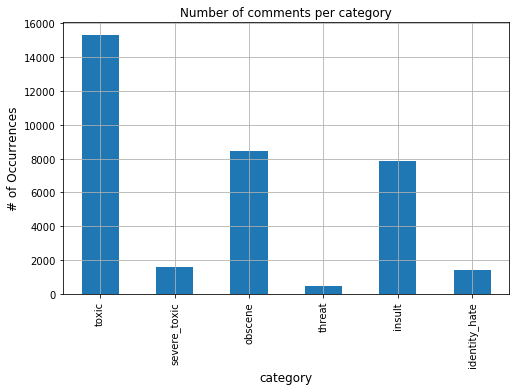

In [12]:
#comments have multi labels
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

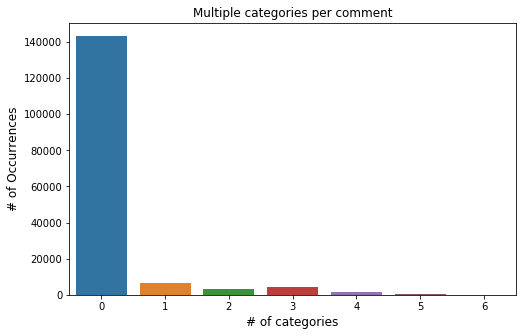

In [13]:
rowsums = train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

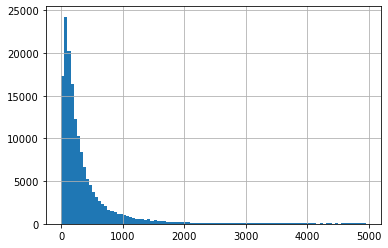

In [14]:
#The distribution of the number of words in comment texts.
lens = train.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

In [67]:
print('Number of missing comments in comment text:')
train['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

## Naive Bayes

Data preprocessing: remove stopwords, punctuation and make text lowercase.

In [69]:
def clean(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

train['comment_text'] = train['comment_text'].map(lambda com : clean(com))
train['comment_text']

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(train, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.externals import joblib
import pickle
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # save model
    joblib.dump(NB_pipeline, category+'_model.pkl')
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))


(71631,)
(35281,)
... Processing toxic
Test accuracy is 0.9204671069414132
... Processing severe_toxic
Test accuracy is 0.9897395198548794
... Processing obscene
Test accuracy is 0.95195714407188
... Processing threat
Test accuracy is 0.9972223009551884
... Processing insult
Test accuracy is 0.9524106459567473
... Processing identity_hate
Test accuracy is 0.9911567132450895


In [85]:
#test
comments = "Really stupid in this place. fuck off you troll!"
comments = pd.Series(comments)
#comments_1 = preprocessing_test(comments, tokenizer)
comments1 = comments.map(lambda com : clean(com))
comments1

0    really stupid in this place fuck off you troll
dtype: object

In [84]:
print('Test Accuracy:')
for category in categories:
    
    # Load from file
    joblib_model = joblib.load(category+'_model.pkl')

    # Calculate the accuracy and predictions
    #score = joblib_model.score(Xtest, Ytest)
    #print("Test score: {0:.2f} %".format(100 * score))
    Ypredict = joblib_model.predict(comments1)
    print(category, Ypredict)

Test Accuracy:
toxic [1]
severe_toxic [0]
obscene [0]
threat [0]
insult [0]
identity_hate [0]


## LTMS Model

In [93]:
dataPath = "../data"
train = pd.read_csv(dataPath + "/train.csv")
test = pd.read_csv(dataPath + "/test.csv")
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Data Pre-processing 
We create a tokenizer, configured to only take into account 100,000 most common words.
Then we build the word index and can recover the word index that was computed, this is also the mapping of how the words are converted to sequence of integers.

Since the sequence may not be of the same length, we are also going to pad the sequence by adding zeros to match the length.

We will save this tokenizer because we are going to apply the same tokenizer to the test data. Thus we can keep the same corpus.


In [18]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

def preprocessing_train(test):
    MAX_NB_WORDS = 100000    # max no. of words for tokenizer
    MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
    VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
    EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
    GLOVE_DIR = "../../Data/Toxic-Thread-Detector/glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"
    texts = [] 
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    for line in tqdm_notebook(test, total=len(test)): 
        texts.append(clean_text(line))
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    return data, tokenizer

def preprocessing_test(test, tokenizer):
    MAX_NB_WORDS = 100000    # max no. of words for tokenizer
    MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
    VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
    EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
    GLOVE_DIR = "../../Data/Toxic-Thread-Detector/glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"
    texts = [] 

    for line in tqdm_notebook(test, total=len(test)): 
        texts.append(clean_text(line))
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    return data

In [ ]:
X = train["comment_text"]
#It takes about 20 minutes to preprocess the data
data, tokenizer = preprocessing_train(X)

In [90]:
print(data)

[[ 7137    39   192 ...     0     0     0]
 [ 2602   896   518 ...     0     0     0]
 [18579   609 37993 ...     0     0     0]
 ...
 [ 2515  1198  1537 ...     0     0     0]
 [36366 35201  1096 ...     0     0     0]
 [  649   305   243 ...     0     0     0]]


In [94]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values
# random shuffle the entries

np.random.seed(1) 
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]

labels = y[indices]

#Create the train-validation split.
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Number of entries in each category:
training:  [12331  1299  6787   381  6361  1130]
validation:  [2963  296 1662   97 1516  275]
Tokenized sentences: 
 [ 2233   480    20    35    23    96  1613    60   301 11488    44     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0  

### Train  LSTM model

In [95]:
word_index = tokenizer.word_index

embeddings_index = {}
f = open(GLOVE_DIR,encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: ../data/glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


__Architecture__: the architecture of this model is

- The input sequence is of length 200. Which is also construting our input layer.
- The embedding layer is like extracting the features from the data. The embedding matrix is constructed with the help of GloVe, which is a pretrained weights downloaded from the standford nlp labs. After the output from this layer will shrinks to 100. 
- And then it is met by a maxpool layer.
- We apply the dropout layer to ensure not to overfit the model.
- We then do a relu dense network to further shinks down the dimension.
- The classifier layer is 6 to match the expected output.

In [96]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="softmax")(x)

model0 = Model(sequence_input, preds)
model0.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model0.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          32467000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 60)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0   

In [40]:
#Train this model takes about 40 minutes.
print('Training progress:')
history = model0.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Train on 127657 samples, validate on 31914 samples
Epoch 1/2
127657/127657 [==============================] - 817s 6ms/sample - loss: 0.2317 - accuracy: 0.9631 - val_loss: 0.2299 - val_accuracy: 0.9644
Epoch 2/2
127657/127657 [==============================] - 795s 6ms/sample - loss: 0.2315 - accuracy: 0.9631 - val_loss: 0.2298 - val_accuracy: 0.9644


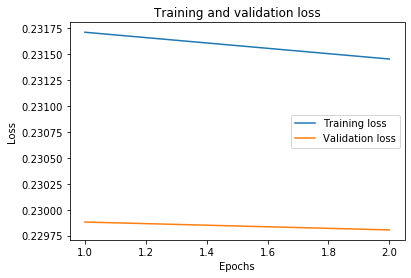

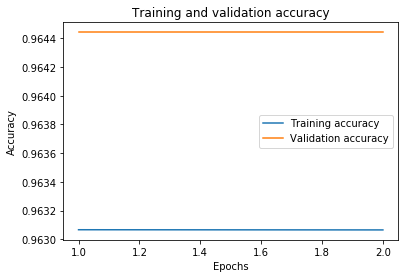

In [41]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

# plot accurancy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

### Test

In [42]:
comments = "Really stupid in this place. fuck off you troll!"
comments = pd.Series(comments)
comments_1 = preprocessing_test(comments, tokenizer)
prediction1 = model.predict(comments_1)
prediction1

[array([[0.5383628]], dtype=float32),
 array([[0.42010295]], dtype=float32),
 array([[0.51511616]], dtype=float32),
 array([[0.4491531]], dtype=float32),
 array([[0.4798976]], dtype=float32),
 array([[0.69885904]], dtype=float32)]

## LTSM-6Layers-Model 

- This approach is very similar to the the one-vs-rest methods when dealing with multi-label classification problem.
- We basically performs a classification tasks four times when it comes to the final layer (dense) to get a expected binary outcome.
- This is the best model to solve this model and it is giving a very good result.
- We save the model file to use for deployment.

In [97]:
y = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=42)

In [98]:
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

In [100]:
#Using embedding_matrix that once calculated
vocab_size = len(word_index)+1
input_1 = Input(shape=(200,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     32467000    input_9[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          117248      embedding_2[0][0]                
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 1)            129         lstm_2[0][0]                     
____________________________________________________________________________________________

In [1]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=32, epochs=5, verbose=1, validation_split=0.2)

## Test the model
We do the model evaluation and test the data in two ways.

- The evaluation is perform on the hold-out test set we seperated before
- And we also made a "fake" toxic comments to perform sanity check. __(Sorry we don't mean to say that)__

In [2]:
# score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test], verbose=1)

In [107]:
# Forgive us! We just want to experiment!
comments = "Really stupid in this place. fuck off you troll!"
comments = pd.Series(comments)
comments_1 = preprocessing_test(comments, tokenizer)

In [108]:
pred = model.predict(comments_1)
result = []
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
for p in pred:
    result.append(float(p[0]))
print(dict(zip(labels, result)))

{'toxic': 0.9196690917015076, 'severe_toxic': 0.025544999167323112, 'obscene': 0.7885405421257019, 'threat': 0.0068905968219041824, 'insult': 0.42700138688087463, 'identity_hate': 0.02542535960674286}


### Save the model 

It is only going to save the last model which we actually use for deployment. 

#### Please run the app.py if you want to play around with our app.

In [109]:
import h5py
model.save('../app/model/ltsm_model.h5', save_format = 'tf')

In [110]:
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from tensorflow.keras.models import load_model
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    new_model_2 = load_model('../app/model/ltsm_model.h5')

In [111]:
new_model_2.predict(comments_1)

[array([[0.9196691]], dtype=float32),
 array([[0.025545]], dtype=float32),
 array([[0.78854054]], dtype=float32),
 array([[0.0068906]], dtype=float32),
 array([[0.4270014]], dtype=float32),
 array([[0.02542536]], dtype=float32)]

In [114]:
# save tokenizer
import json
tokenizer_json = tokenizer.to_json()
with open('../app/model/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [116]:
from keras_preprocessing.text import tokenizer_from_json
with open('../app/model/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)